<a href="https://colab.research.google.com/github/Luisinho-31/S-P500/blob/main/Series_de_tiempo_SP500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series de tiempo:
## S&P 500
En este colab veremos como predecir el comportamiento de las acciones que estan en el S&P 500, se utilizaran dos modelos: ARIMA y Facebook Prophet


*   Informacion obtenida: https://www.kaggle.com/datasets/camnugent/sandp500


### Importacion de Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import ast


###Acceso a Kaggle

In [ ]:
kaggle_ruta={"username":"luis1fernando2","key":"482787f29968a774bda7c9f64fe48a74"}

In [ ]:
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_ruta, f)
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descarga el dataset de S&P 500
!kaggle datasets download -d camnugent/sandp500
!unzip sandp500.zip

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/camnugent/sandp500
License(s): CC0-1.0
sandp500.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sandp500.zip
replace all_stocks_5yr.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: all_stocks_5yr.csv      
replace getSandP.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: getSandP.py             
replace individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._.DS_Store  
replace individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._AAPL_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._AAPL_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._AAPL_dat

In [ ]:
df = pd.read_csv("all_stocks_5yr.csv")
df.shape

(619040, 7)

# Preprocesamiento de Datos

#Valores Nulos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [ ]:
# Revisamos si hay valores nulos o ceros

def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [ ]:
# Como podemos observar de la mayoria de los datos no tienen valores nulos, solo hay 11 valores missing en el dataset
missing_zero_values_table(df)


Your selected dataframe has 7 columns and 619040 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
open,0,11,0.0,11,0.0,float64
high,0,8,0.0,8,0.0,float64
low,0,8,0.0,8,0.0,float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [ ]:
# Convertimos la columna date a datetime para un mejor manejo de datos
df['date'] = pd.to_datetime(df['date'])

In [ ]:
#tomaremos diez datos al azar para ver el comportamiento de cada accion
list_unique = df.Name.unique()
values_random = np.random.choice(list_unique, 10)
# Obtenemos 10 valores aleatorios
values_random

array(['UNP', 'COTY', 'GT', 'UNH', 'TROW', 'HRB', 'IBM', 'EQT', 'PG',
       'IRM'], dtype=object)

In [ ]:
accion = 'MET'
df_accion = df[df['Name'] == accion].copy()
df_accion.head()

,date,open,high,low,close,volume,Name
372572,2013-02-08,36.96,37.11,36.71,36.90,4899965,MET
372573,2013-02-11,36.89,37.10,36.68,36.90,4571956,MET
372574,2013-02-12,36.92,37.28,36.81,37.13,6302675,MET
372575,2013-02-13,37.20,37.85,36.97,37.50,9129768,MET
372576,2013-02-14,37.04,37.23,36.03,36.69,20884203,MET


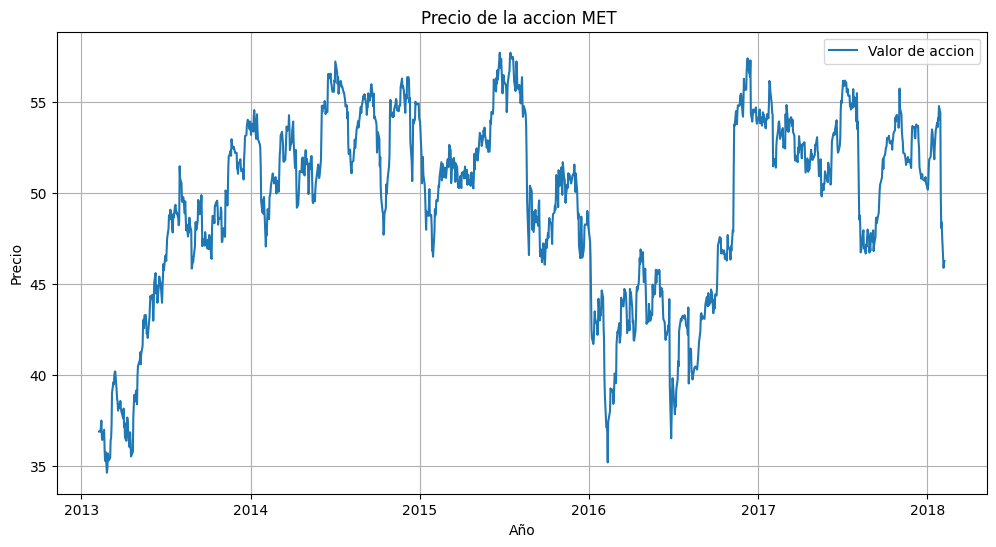

In [ ]:
# Obtenemos el grafico de comportamiento por precio de la accion

plt.figure(figsize=(12, 6))
plt.plot(df_accion['date'], df_accion['close'], label='Valor de accion')
plt.title(f'Precio de la accion {accion} ')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# Modelos
Se realizó el despliegue de dos modelos de series de tiempo, Arima y Prophet, esto con el fin de comparar los resultados de cada uno, asi como la prediccion a cierto tiempo
Al igual se utiliza un menú desplegable para seleccionar aquella acción que se requiera visualizar

#Arima

In [ ]:
# Importamos la libreria ARIMA
#importamos ipwidget para tomar valores desde una lista desplegable
from statsmodels.tsa.arima.model import ARIMA
import ipywidgets as widgets
from ipywidgets import interact, Dropdown, IntSlider

In [ ]:
def funcion_arima(df, name_accion):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    # filtramos por nombre de la accion
    accion = df[df['Name'] == name_accion].copy()
    accion.set_index('date', inplace=True)

    # Entrenamiento del modelo ARIMA
    model = ARIMA(accion['close'], order=(5, 1, 0))
    model_fit = model.fit()

    # Realizamo el pronostico y fechas futuras
    future = model_fit.forecast(steps=300)
    fechas_forecast = pd.date_range(start=accion.index[-1] + pd.Timedelta(days=1), periods=300, freq='B')


    return accion, future, fechas_forecast

In [ ]:
def graficar_con_matplotlib(change):
    name_accion = change['new']

    accion, future, fechas_forecast = funcion_arima(df, name_accion)

    plt.figure(figsize=(12,6))
    plt.plot(accion['close'], label='Histórico')
    plt.plot(fechas_forecast, future, label='Pronóstico', color='green')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.title(f'Precio acción {name_accion}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# seleccionamos el valore de la accion que queremos ver
menu = widgets.Dropdown(
    options=df['Name'].unique(),
    value='AAPL',
    description='Acción:',
    style={'description_width': 'initial'}
)
display(menu)

Dropdown(description='Acción:', index=1, options=('AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', '…

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

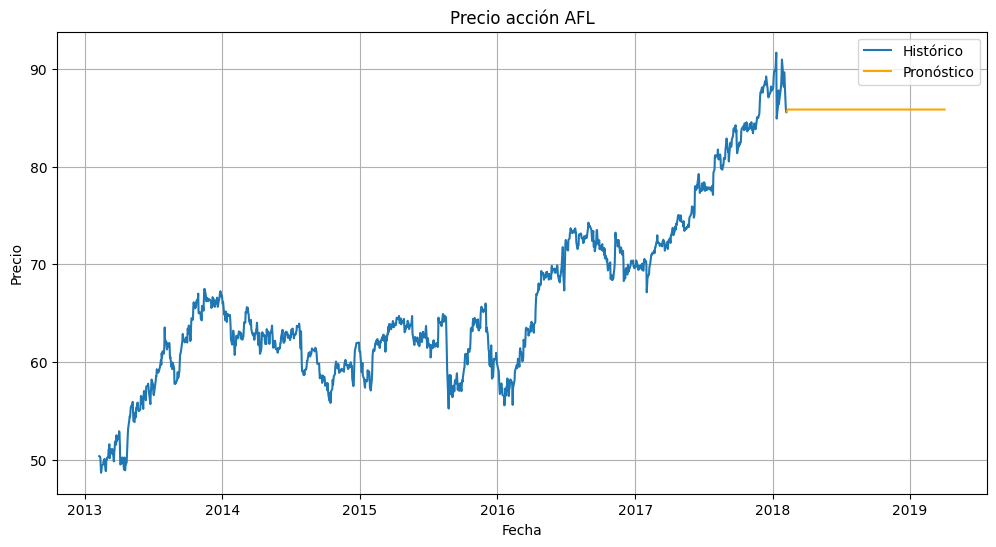

In [ ]:
# Graficamos la accion
graficar_con_matplotlib({'new': menu.value})

# PROPHET

In [ ]:
# !pip install prophet --quiet

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from prophet import Prophet
import pandas as pd


In [ ]:

# Se crea funcion para el modelo prophet
def funcion_prophet(df, name_accion):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    accion = df[df['Name'] == name_accion].copy()
    # Asignamos la variable date y la columna predictora
    accion = accion[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})

    model = Prophet(daily_seasonality=True)
    model.fit(accion)

    # se asigna la cantidad de dias a predecir
    future = model.make_future_dataframe(periods=90)
    forecast = model.predict(future)

    return accion, forecast

In [ ]:

menu = widgets.Dropdown(
    options=df['Name'].unique(),
    value='AAPL',
    description='Acción:'
)

In [ ]:
def graficar_funcion_prophet(change):
    name_accion = change['new']
    accion, forecast = funcion_prophet(df, name_accion)

    plt.figure(figsize=(12,6))
    plt.plot(accion['ds'], accion['y'], label='Histórico')
    plt.plot(forecast['ds'], forecast['yhat'], label='Pronóstico', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='green', alpha=0.2, label='Confianza')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.title(f'Precio acción {name_accion} (modelo Prophet)')
    plt.legend()
    plt.grid(True)
    plt.show()


Dropdown(description='Acción:', index=17, options=('AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', …

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd46bnr1q/1xnnbzze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd46bnr1q/vorfwpbl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13995', 'data', 'file=/tmp/tmpd46bnr1q/1xnnbzze.json', 'init=/tmp/tmpd46bnr1q/vorfwpbl.json', 'output', 'file=/tmp/tmpd46bnr1q/prophet_model0ys4wcmo/prophet_model-20250711080840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:08:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


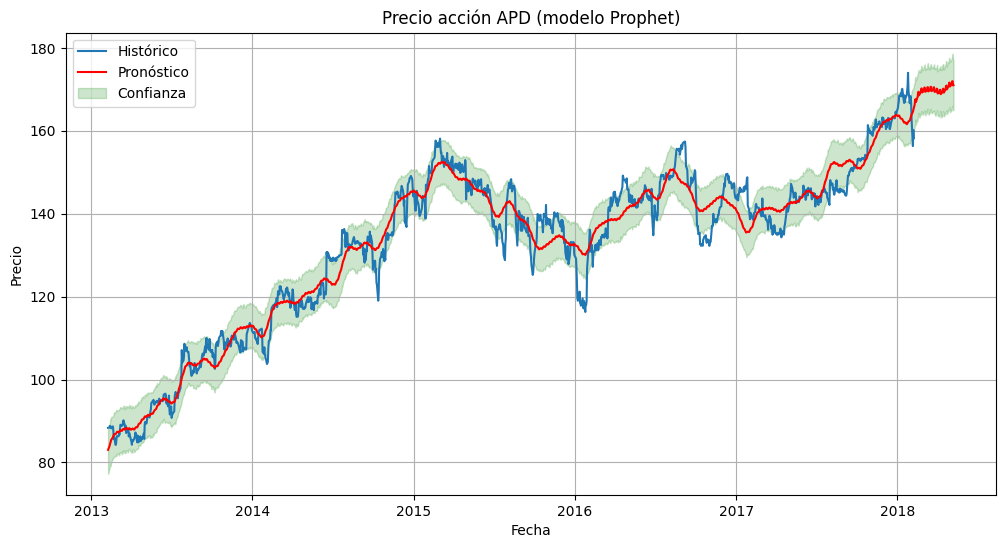

In [ ]:
# Seleecionamos la accion con un dropdown
menu.observe(graficar_funcion_prophet, names='value')
display(menu)



In [ ]:
menu.value

'ARNC'

In [ ]:
# Mostrar gráfico inicial
# graficar_funcion_prophet({'new': menu.value})

## ENTRENAMIENTO

In [ ]:
# Instalamos las librerias prophet  y cmdstanpy
!pip install prophet --quiet
!pip install --quiet cmdstanpy
from prophet import Prophet


In [ ]:
# Prepare data for Prophet
prophet_df = df[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})

model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd46bnr1q/ihnfb6oe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd46bnr1q/ndb0vmh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74995', 'data', 'file=/tmp/tmpd46bnr1q/ihnfb6oe.json', 'init=/tmp/tmpd46bnr1q/ndb0vmh2.json', 'output', 'file=/tmp/tmpd46bnr1q/prophet_modelcb5v6r0g/prophet_model-20250711075720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df.info()
df_1 = df.rename(columns={'date':'ds','close':'y'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [ ]:
# Tomaremos los ultimos 45 dias para el el entrenamiento
df_1_train = df_1.tail(45)
df_1_test = df_1.tail(45)
df_1_train.shape

(45, 7)

In [ ]:
model = Prophet(daily_seasonality=True)
model.fit(df_1_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd46bnr1q/wc0g_o87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd46bnr1q/jis4licm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73920', 'data', 'file=/tmp/tmpd46bnr1q/wc0g_o87.json', 'init=/tmp/tmpd46bnr1q/jis4licm.json', 'output', 'file=/tmp/tmpd46bnr1q/prophet_modelm69j63xv/prophet_model-20250711075907.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

In [ ]:
menu.value
df_1

,date,open,high,low,close,volume,Name
37574,2013-02-08,13.41,13.680,13.360,13.61,16950482,AMAT
37575,2013-02-11,13.56,13.750,13.480,13.66,13240556,AMAT
37576,2013-02-12,13.67,13.690,13.470,13.66,11712555,AMAT
37577,2013-02-13,13.77,13.790,13.615,13.77,11635605,AMAT
37578,2013-02-14,13.86,13.990,13.650,13.89,20124979,AMAT
...,...,...,...,...,...,...,...
38828,2018-02-01,53.16,54.180,52.930,53.28,9706003,AMAT
38829,2018-02-02,52.58,52.790,50.520,50.68,16813121,AMAT
38830,2018-02-05,49.98,51.465,48.310,48.31,17999698,AMAT
38831,2018-02-06,47.41,50.260,46.400,50.25,21455699,AMAT


# Evaluacion del modelo

In [ ]:
df_1 = df[df['Name']== menu.value].copy()
ultimos_dias = df_1.tail(45).copy()
ultimos_dias['date'] = pd.to_datetime(ultimos_dias['date'])

ultimos_dias = ultimos_dias.rename(columns={'date': 'ds'})

# Hace merge con forecast (solo columna 'ds' y 'yhat')
df_1_resultaldo = pd.merge(df_1_resultaldo, forecast[['ds', 'yhat']], on='ds', how='left')
df_1_resultaldo = df_1_resultaldo.rename(columns={'yhat': 'prediccion'})

df_1_resultaldo

,ds,open,high,low,close,volume,Name,yhat_x,yhat_y,prediccion
0,2013-02-08,13.41,13.680,13.360,13.61,16950482,AMAT,NaN,NaN,NaN
1,2013-02-11,13.56,13.750,13.480,13.66,13240556,AMAT,NaN,NaN,NaN
2,2013-02-12,13.67,13.690,13.470,13.66,11712555,AMAT,NaN,NaN,NaN
3,2013-02-13,13.77,13.790,13.615,13.77,11635605,AMAT,NaN,NaN,NaN
4,2013-02-14,13.86,13.990,13.650,13.89,20124979,AMAT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1254,2018-02-01,53.16,54.180,52.930,53.28,9706003,AMAT,76.545697,76.545697,76.545697
1255,2018-02-02,52.58,52.790,50.520,50.68,16813121,AMAT,76.310381,76.310381,76.310381
1256,2018-02-05,49.98,51.465,48.310,48.31,17999698,AMAT,75.049202,75.049202,75.049202
1257,2018-02-06,47.41,50.260,46.400,50.25,21455699,AMAT,74.527411,74.527411,74.527411


In [ ]:
#Calculamos el error mae
error_mae = abs(df_1_resultaldo['close'] - df_1_resultaldo['prediccion']).mean()
print(f'Error absoluto medio (MAE): {error_mae}')


Error absoluto medio (MAE): 21.04


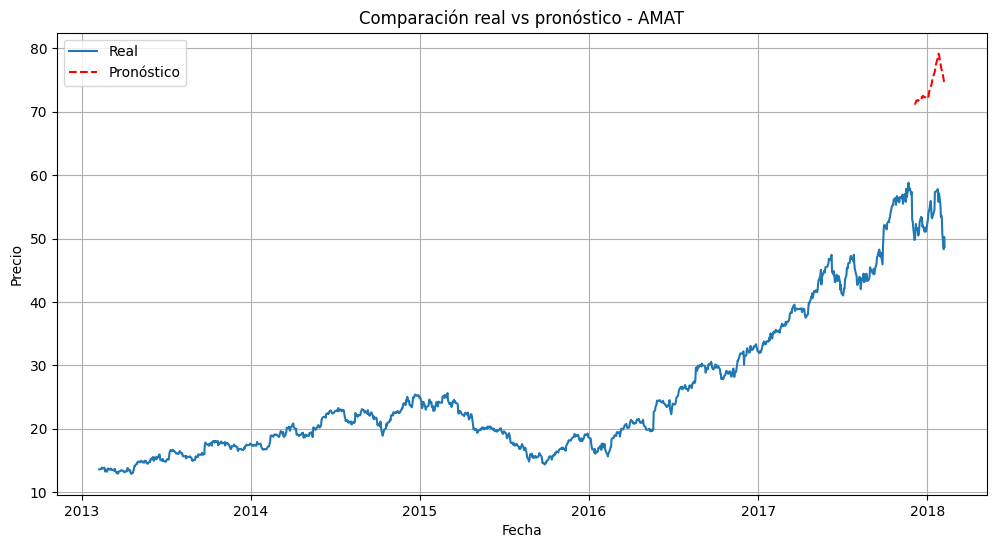

In [ ]:
#Graficamos el real vs. Pronostico por cada accion
plt.figure(figsize=(12,6))
plt.plot(df_1_resultaldo['ds'], df_1_resultaldo['close'], label='Real')
plt.plot(df_1_resultaldo['ds'], df_1_resultaldo['prediccion'], label='Pronóstico', linestyle='--', color='red')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title(f"Comparación real vs pronóstico - {menu.value}")
plt.legend()
plt.grid(True)
plt.show()